In [176]:
from utils.data import FilePaths, read_image_file, rmse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [195]:
n_c = 30
n_h = 150

I_C = read_image_file(FilePaths.INDEX_C)
I_H = read_image_file(FilePaths.INDEX_H)
T_C = read_image_file(FilePaths.TEMP_C)
T_H = read_image_file(FilePaths.TEMP_H)
A_C = read_image_file(FilePaths.ALBEDO_C)
A_H = read_image_file(FilePaths.ALBEDO_H)
C_C = read_image_file(FilePaths.CLASS_C)
C_H = read_image_file(FilePaths.CLASS_H)

ALBEDO_LOW = T_C.min() - 5
ALBEDO_HIGH = T_C.max() + 5

cuda = True if torch.cuda.is_available() else False
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def stack_inputs(inputs: tuple):
    x = np.stack(inputs, axis=1)
    y = T_C.flatten()[:, np.newaxis]
    return x, y

In [196]:
# Normalization
mIc, sIc = np.mean(I_C), np.std(I_C)
mAc, sAc = np.mean(A_C), np.std(A_C)
mCc, sCc = np.mean(C_C), np.std(C_C)
mTc, sTc = np.mean(T_C), np.std(T_C)

I_C = (I_C - mIc) / sIc
A_C = (A_C - mAc) / sAc
C_C = (C_C - mCc) / sCc
T_C = (T_C - mTc) / sTc

#Create dataloader
n_input = 2
one_input = (I_C.flatten(),)
two_inputs = (I_C.flatten(), A_C.flatten())
three_inputs = (I_C.flatten(), A_C.flatten(), C_C.flatten())
X, Y = stack_inputs(two_inputs)

class RegressionDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        return x, y

class ToTensor(object):
    def __call__(self, sample):
        return torch.FloatTensor(sample).to(dev)

dataset = RegressionDataset(X, Y, transform=ToTensor())
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
class Regressor(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.lin1 = nn.Sequential( 
            nn.Linear(in_c, 256, bias = False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            )
        self.lin2 = nn.Sequential(
            nn.Linear(256, 512, bias = False),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            )
        self.lin3 = nn.Sequential(
            nn.Linear(512, 1, bias = False),
            nn.BatchNorm1d(1),
            )
        
    def forward(self, z):    
        out  = self.lin1(z)
        out  = self.lin2(out)
        out  = self.lin3(out)
        return out

In [198]:
model = Regressor(n_input).to(dev)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 50
for epoch in range(n_epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/50, Loss: 0.9727
Epoch 2/50, Loss: 0.7125
Epoch 3/50, Loss: 0.7113
Epoch 4/50, Loss: 0.7122
Epoch 5/50, Loss: 0.6694
Epoch 6/50, Loss: 0.6581
Epoch 7/50, Loss: 0.6435
Epoch 8/50, Loss: 0.6397
Epoch 9/50, Loss: 0.6549
Epoch 10/50, Loss: 0.6382
Epoch 11/50, Loss: 0.6325
Epoch 12/50, Loss: 0.6200
Epoch 13/50, Loss: 0.6225
Epoch 14/50, Loss: 0.6146
Epoch 15/50, Loss: 0.5962
Epoch 16/50, Loss: 0.5900
Epoch 17/50, Loss: 0.5828
Epoch 18/50, Loss: 0.5762
Epoch 19/50, Loss: 0.5846
Epoch 20/50, Loss: 0.5757
Epoch 21/50, Loss: 0.5682
Epoch 22/50, Loss: 0.5597
Epoch 23/50, Loss: 0.5818
Epoch 24/50, Loss: 0.5693
Epoch 25/50, Loss: 0.6007
Epoch 26/50, Loss: 0.5894
Epoch 27/50, Loss: 0.5547
Epoch 28/50, Loss: 0.5614
Epoch 29/50, Loss: 0.5577
Epoch 30/50, Loss: 0.5744
Epoch 31/50, Loss: 0.5495
Epoch 32/50, Loss: 0.5662
Epoch 33/50, Loss: 0.5560
Epoch 34/50, Loss: 0.5482
Epoch 35/50, Loss: 0.5706
Epoch 36/50, Loss: 0.5659
Epoch 37/50, Loss: 0.5408
Epoch 38/50, Loss: 0.5346
Epoch 39/50, Loss: 0.

In [199]:
T_C_pred = model(torch.FloatTensor(X).to(dev)).detach().cpu().numpy()
T_C_pred_real = T_C_pred * sTc + mTc

In [200]:
rmse(
    T_C, T_C_pred.reshape((n_c, n_c))
)

np.float32(0.51234096)

In [201]:
one_input_h = (I_H.flatten(),)
two_inputs_h = (I_H.flatten(), A_H.flatten())
three_inputs_h = (I_H.flatten(), A_H.flatten(), C_H.flatten())

X_H = np.stack(two_inputs_h, axis=1)
T_H_reg = model(torch.FloatTensor(X_H).to(dev))

In [202]:
T_H_reg = T_H_reg.cpu().detach().numpy().reshape((n_h, n_h))*sTc + mTc

In [203]:
rmse(
    T_H, T_H_reg
)

np.float32(18.443094)

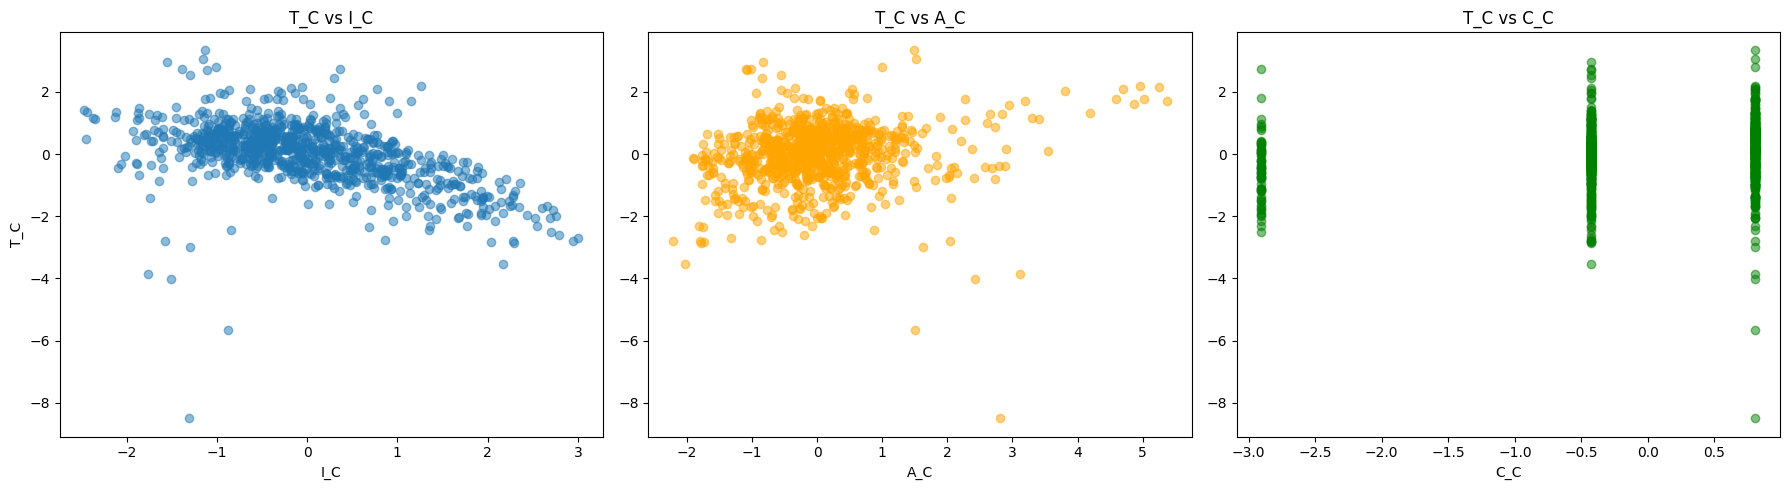

In [177]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(I_C.flatten(), T_C.flatten(), alpha=0.5)
axs[0].set_title('T_C vs I_C')
axs[0].set_xlabel('I_C')
axs[0].set_ylabel('T_C')

axs[1].scatter(A_C.flatten(), T_C.flatten(), alpha=0.5, color='orange')
axs[1].set_title('T_C vs A_C')
axs[1].set_xlabel('A_C')

axs[2].scatter(C_C.flatten(), T_C.flatten(), alpha=0.5, color='green')
axs[2].set_title('T_C vs C_C')
axs[2].set_xlabel('C_C')

plt.tight_layout()
plt.show()